# Analyze generic genes and pathways

This notebook uses the DEG and GSEA statistics obtained from the previous notebooks [3_gene_DE_analysis](3_gene_DE_analysis.ipynb) and [4_pathway enrichment analysis](4_pathway_enrichment_analysis.ipynb) to: 
1. Determine if our simulation approach can identify a set of generic genes and pathways
2. Compare our set of generic genes and pathways with what has been previously reported

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import random
import warnings
import rpy2.robjects
import seaborn as sns

from plotnine import (ggplot,
                      labs,   
                      geom_point,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      xlim,
                      ylim,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

sys.path.append("../")
from functions import utils

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "Rank_pathways",
                                           "init_config.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
col_to_rank = 'logFC'

In [4]:
# Input files
gene_summary_file = os.path.join(
    local_dir, 
    "gene_summary_table_"+col_to_rank+".tsv")

pathway_summary_file = os.path.join(
    local_dir, 
    "pathway_summary_table_"+col_to_rank+".tsv")

## Generic genes

### Map gene ids
Our gene ids are ensembl while the published gene ids are using hgnc symbols. We need to map ensembl to hgnc ids in order to compare results.

In [5]:
#%%R
#suppressWarnings(library("biomaRt"))

In [6]:
#%%R -i gene_summary_file -o gene_id_mapping
# Convert gene ids from ensembl (ours) to entrez (DE_prior)

#source('../functions/GSEA_analysis.R')

#gene_id_mapping <- get_ensembl_symbol_mapping(gene_summary_file)

In [7]:
# Set ensembl id as index
#gene_id_mapping.set_index("ensembl_gene_id", inplace=True)
#print(gene_id_mapping.shape)
#gene_id_mapping.head()

In [8]:
# Save 
#gene_id_file = os.path.join(
#    local_dir,
#    "ensembl_hgnc_mapping.tsv")
#gene_id_mapping.to_csv(gene_id_file, float_format='%.5f', sep='\t')

In [9]:
# Read file mapping ensembl ids to hgnc symbols
gene_id_file = os.path.join(
    local_dir,
    "ensembl_hgnc_mapping.tsv")

gene_id_mapping = pd.read_csv(
    gene_id_file,
    header=0,
    sep='\t',
    index_col=0)

In [10]:
# Replace ensembl ids with gene symbols
# Only replace if ensembl ids exist
if gene_id_mapping.shape[0] > 0:
    utils.replace_ensembl_ids(gene_summary_file,
                          gene_id_mapping)

### Our DEGs
Genes are ranked by their adjusted p-value and the median rank reported across 25 simulated experiments is shown in column `Median rank (simulated)`.

In [11]:
# Read data
gene_stats = pd.read_csv(
    gene_summary_file,
    header=0,
    sep='\t',
    index_col=0)
print(gene_stats.shape)
gene_stats.head()

(17810, 10)


,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
IGHG1,ENSG00000211896.7,0.03446,17809.0,4217.28509,0.00280,17796.0,241.24924,292.11299,25,13.61129
SCGB3A1,ENSG00000161055.3,0.10740,17807.0,2953.13558,0.04015,17678.0,85.64603,145.96075,25,19.64562
CEACAM6,ENSG00000086548.8,0.00175,17806.0,682.86373,0.00076,17768.0,81.22895,93.15353,25,6.45853
IGLL5,ENSG00000254709.7,0.01063,17804.0,605.22586,0.00484,17068.0,38.42943,88.16046,25,6.42915
COL1A1,ENSG00000108821.13,0.03039,17798.0,372.52724,0.00092,17586.0,-25.24062,45.49906,25,8.74233


In [12]:
# Get list of our genes
gene_ids = list(gene_stats.index)

### Published DEGs
These DEGs are based on the [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf). Their genes are ranked 0 = not commonly DE; 1 = commonly DE. Genes by the number differentially expressed gene sets they appear in and then ranking genes by this score.

In [13]:
# Get generic genes identified by Crow et. al.
DE_prior_file = "https://raw.githubusercontent.com/maggiecrow/DEprior/master/DE_Prior.txt"

DE_prior = pd.read_csv(DE_prior_file,
                       header=0,
                       sep="\t")

DE_prior.head()

,Gene_Order,Gene_EntrezID,N_HitLists,DE_Prior_Rank,Gene_Name
0,1,7503,79,1.000000,XIST
1,2,8653,64,0.999948,DDX3Y
2,3,9086,62,0.999870,EIF1AY
3,4,8284,52,0.999870,KDM5D
4,5,8287,46,0.999791,USP9Y


In [14]:
# Get list of published generic genes
published_generic_genes = list(DE_prior['Gene_Name'])

### Compare DEG ranks

In [15]:
# Get intersection of gene lists
shared_genes = set(gene_ids).intersection(published_generic_genes)
print(len(shared_genes))
# check that all our genes are a subset of the published ones, no genes unique to ours

17787


In [16]:
# Get genes only in ours not theirs
#our_unique_genes = set(gene_ids) - set(shared_genes)
#print(len(our_unique_genes))
#our_unique_genes

In [17]:
# Get rank of intersect genes
our_gene_rank_df = pd.DataFrame(gene_stats.loc[shared_genes,'Rank (simulated)'])
print(our_gene_rank_df.shape)
our_gene_rank_df.head()

(17810, 1)


,Rank (simulated)
OCA2,3201.0
COG5,7409.0
UNC5CL,9690.0
SLC8B1,9798.0
ADAM2,2210.0


In [18]:
# Merge published ranking
shared_gene_rank_df = pd.merge(our_gene_rank_df,
                                        DE_prior[['DE_Prior_Rank','Gene_Name']],
                                        left_index=True,
                                        right_on='Gene_Name')

shared_gene_rank_df.set_index('Gene_Name', inplace=True)
print(shared_gene_rank_df.shape)
shared_gene_rank_df.head()

(17810, 2)


,Rank (simulated),DE_Prior_Rank
Gene_Name,,
OCA2,3201.0,0.806515
COG5,7409.0,0.336141
UNC5CL,9690.0,0.762440
SLC8B1,9798.0,0.228354
ADAM2,2210.0,0.043292


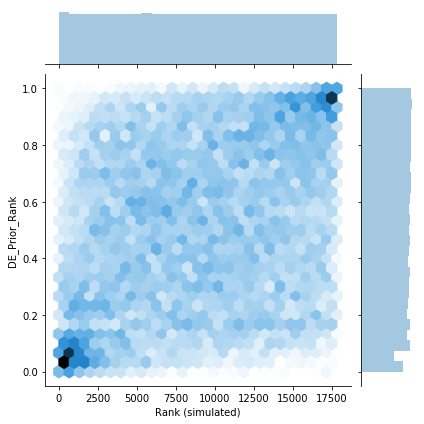

In [19]:
# Plot our ranking vs published ranking
sns.jointplot(data=shared_gene_rank_df,
              x='Rank (simulated)',
              y='DE_Prior_Rank',
             kind='hex')

# Make prettier if better way to show it

### Calculate correlation

In [20]:
#%%R
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("RVAideMemoire")
#deps <- c("ade4", "car", "cramer", "dunn.test", "FactoMineR", 
#       "lme4", "mixOmics", "multcompView", "pls", "pspearman",
#       "statmod", "vegan")
#install.packages(deps)

In [21]:
#%%R
#library(RVAideMemoire)

In [22]:
from scipy import stats

def spearmanr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.spearmanr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [23]:
spearmanr_ci(shared_gene_rank_df['Rank (simulated)'],
            shared_gene_rank_df['DE_Prior_Rank'])

(0.292113201272114, 0.0, 0.2786219243145159, 0.305489213478507)

In [24]:
#Spearman R^2 value: 0.29211
#CI: (0.2786,0.3054)

SyntaxError: invalid syntax (<ipython-input-24-9c56c1cb3a2d>, line 1)

In [ ]:
#%%R -i shared_gene_rank_df 

#our_rank <- shared_gene_rank_df[,1]
#their_rank <- shared_gene_rank_df[,2]

#spearman.ci(our_rank, their_rank, nrep = 1000, conf.level = 0.95)

In [ ]:
# Calculate correlation between ours vs DE_prior ranking


## Generic pathways

In [ ]:
"""
# Read data
pathway_stats = pd.read_csv(
    pathway_summary_file,
    header=0,
    sep='\t',
    index_col=0)

pathway_stats.head()"""

In [ ]:
"""# Define what are the set of generic genes
generic_pathway_data = pathway_stats.sort_values(by="Z score", ascending=True)[0:10]

generic_pathway_data.head()"""

In [ ]:
# Manually compare against Powers et. al publication 
# https://academic.oup.com/bioinformatics/article/34/13/i555/5045793